In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# import data
train_df = pd.read_csv('train.csv', dtype=np.float32)
test_df = pd.read_csv('test.csv', dtype=np.float32)

# separate features/labels
targets_np = train_df.label.values
features_np = train_df.loc[:, train_df.columns != 'label'].values/255

# split train/dev sets
features_train, features_dev, targets_train, targets_dev = train_test_split(
    features_np, targets_np, test_size=0.025, random_state=42)

# create tensors
features_train_tensor = torch.from_numpy(features_train)
targets_train_tensor = torch.from_numpy(targets_train).type(torch.LongTensor)
features_dev_tensor = torch.from_numpy(features_dev)
targets_dev_tensor = torch.from_numpy(targets_dev).type(torch.LongTensor)

# batch size, iterations, epochs
batch_size = 100
n_iters = 10000
num_epochs = int(n_iters / (len(features_train_tensor) / batch_size))

# create tensor datasets
train_dataset = TensorDataset(features_train_tensor, targets_train_tensor)
dev_dataset = TensorDataset(features_dev_tensor, targets_dev_tensor)

# data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

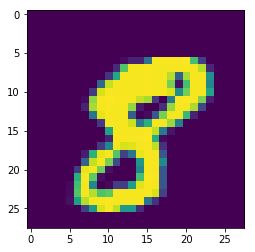

In [3]:
# visualize an item in the dataset
plt.imshow(features_np[10].reshape(28,28))

In [4]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        # input dimensions (28)
        self.input_dim = input_dim
        
        # number of units in hidden layer
        self.hidden_dim = hidden_dim
        
        # number of layers
        self.layer_dim = layer_dim
        
        # RNN
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)  # batch_first=True (batch_dim, seq_dim, feature_dim)
        
        # output layer (fully-connected)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # initialize hidden state with 0s
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # initialize cell state with 0s
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :])
        return out

In [5]:
# Create LSTM
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10
learning_rate = 0.1

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
error = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [6]:
# training
seq_dim = 28 # (28, input_dim) = (28,28)
loss_list = []
iteration_list = []
accuracy_list = []
count = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        
        # reshape input to (28,28)
        train_images = Variable(images.view(-1, seq_dim, input_dim))
        train_labels = Variable(labels)
        
        # clear gradients
        optimizer.zero_grad()
        
        # forward propagation
        output = model(train_images)
        
        # calculate loss
        loss = error(output, train_labels)
        
        # backpropgation
        loss.backward()
        
        # update parameters (gradient descent)
        optimizer.step()
        
        count += 1
        
        # evaluate model accuracy every 250 iterations
        if count % 250 == 0:
            correct, total = 0, 0
            for dev_images, dev_labels in dev_dataloader:
                train_images = Variable(images.view(-1, seq_dim, input_dim))
                
                # forward propagation
                output = model(train_images)
                
                # get predictions
                predicted = torch.max(output.data, 1)[1]
                
                # track accuracy
                total += labels.size(0)
                correct += (predicted == labels).sum()
                
            accuracy = 100 * (correct / float(total))
            
            accuracy_list.append(accuracy)
            loss_list.append(loss.data)
            iteration_list.append(count)
            
            if count % 500 == 0:
                print(f'Iteration: {count}, Loss: {loss.data.item()}, Accuracy: {accuracy}')

Iteration: 500, Loss: 2.274273157119751, Accuracy: 15.000000953674316
Iteration: 1000, Loss: 1.0338528156280518, Accuracy: 72.0
Iteration: 1500, Loss: 0.48661869764328003, Accuracy: 90.0
Iteration: 2000, Loss: 0.10615992546081543, Accuracy: 99.0
Iteration: 2500, Loss: 0.26663342118263245, Accuracy: 94.0
Iteration: 3000, Loss: 0.2029847353696823, Accuracy: 97.0
Iteration: 3500, Loss: 0.042534131556749344, Accuracy: 100.0
Iteration: 4000, Loss: 0.02540951408445835, Accuracy: 100.0
Iteration: 4500, Loss: 0.08786550164222717, Accuracy: 99.0
Iteration: 5000, Loss: 0.04727480933070183, Accuracy: 99.0
Iteration: 5500, Loss: 0.013841914013028145, Accuracy: 100.0
Iteration: 6000, Loss: 0.05872076004743576, Accuracy: 100.0
Iteration: 6500, Loss: 0.028702624142169952, Accuracy: 99.0
Iteration: 7000, Loss: 0.02545486018061638, Accuracy: 100.0
Iteration: 7500, Loss: 0.07250182330608368, Accuracy: 99.0
Iteration: 8000, Loss: 0.05988820642232895, Accuracy: 100.0
Iteration: 8500, Loss: 0.0392045937478

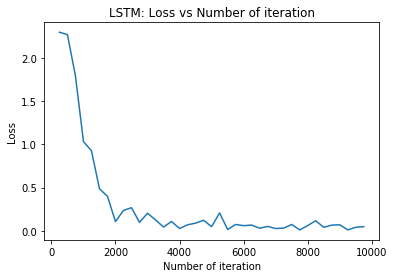

Text(0.5,1,'LSTM: Accuracy vs Number of iteration')

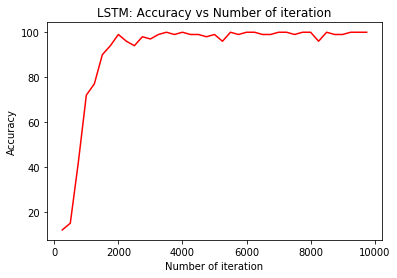

In [9]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("LSTM: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("LSTM: Accuracy vs Number of iteration")

In [10]:
# save model
torch.save(model, './digit-recognizer-lstm-model.pt') 